In [ ]:
from models.lstm_ad import LSTM_AD
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score
from utils.data import create_sequences

from ipywidgets import IntProgress
from IPython.display import display

In [2]:
class Config:
    train_size = 400
    TIME_STEPS = 50
    epochs = 2
    batch_size = 32
    Q = 0.99

In [49]:
df = pd.read_csv("./data/valve1/0.csv", sep=";", parse_dates=True, index_col="datetime")

df.sort_index(inplace=True)
df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0,0.0,0.0
2020-03-09 10:14:34,0.026170,0.040453,1.35399,0.382638,79.5158,26.0258,236.040,32.0,0.0,0.0
2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0,0.0,0.0
2020-03-09 10:14:36,0.026027,0.039641,1.33458,0.382638,79.6097,26.0393,234.392,32.0,0.0,0.0
2020-03-09 10:14:37,0.026290,0.040273,1.07851,-0.273216,79.6109,26.0420,225.342,32.0,0.0,0.0


In [53]:
SS = StandardScaler()
x_train = np.array(SS.fit_transform(df[:train_size].drop(['anomaly','changepoint'], axis=1)))
x_train = create_sequences(x_train, Config.TIME_STEPS)

In [54]:
lstm_ad = LSTM_AD().fit(x_train)

Epoch 1/2
11/11 [==============================] - 6s 133ms/step - loss: 0.8948
Epoch 2/2
11/11 [==============================] - 2s 143ms/step - loss: 0.7867


In [56]:
x_test = np.array(SS.transform(df.drop(['anomaly','changepoint'], axis=1)))
x_test = create_sequences(x_test, Config.TIME_STEPS)

In [57]:
predictions = lstm_ad.predict(x_test)

In [62]:
r = pd.Series(np.sum(np.mean(np.abs(np.array(predictions) - x_test), axis=1), axis=1))
health_r = r[:train_size]

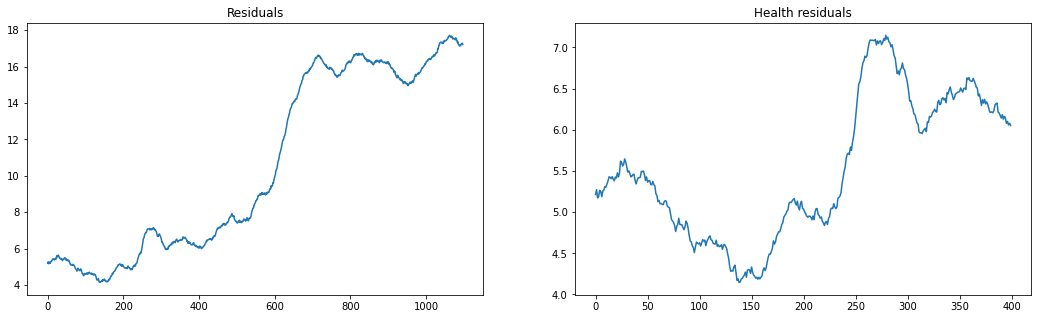

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes[0].plot(r)
axes[0].set_title("Residuals")
axes[1].plot(health_r)
axes[1].set_title("Health residuals")
plt.show()

In [67]:
UCL = health_r.quantile(Config.Q)
anomalous_data = r > (3/2 * UCL)

anomalous_data_indices = [] 
for data_idx in range(TIME_STEPS - 1, len(x_test) - TIME_STEPS + 1):
    if np.all(anomalous_data[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx - int(TIME_STEPS // 6))

prediction = pd.Series(data=0, index=df.index)
prediction.iloc[anomalous_data_indices] = 1

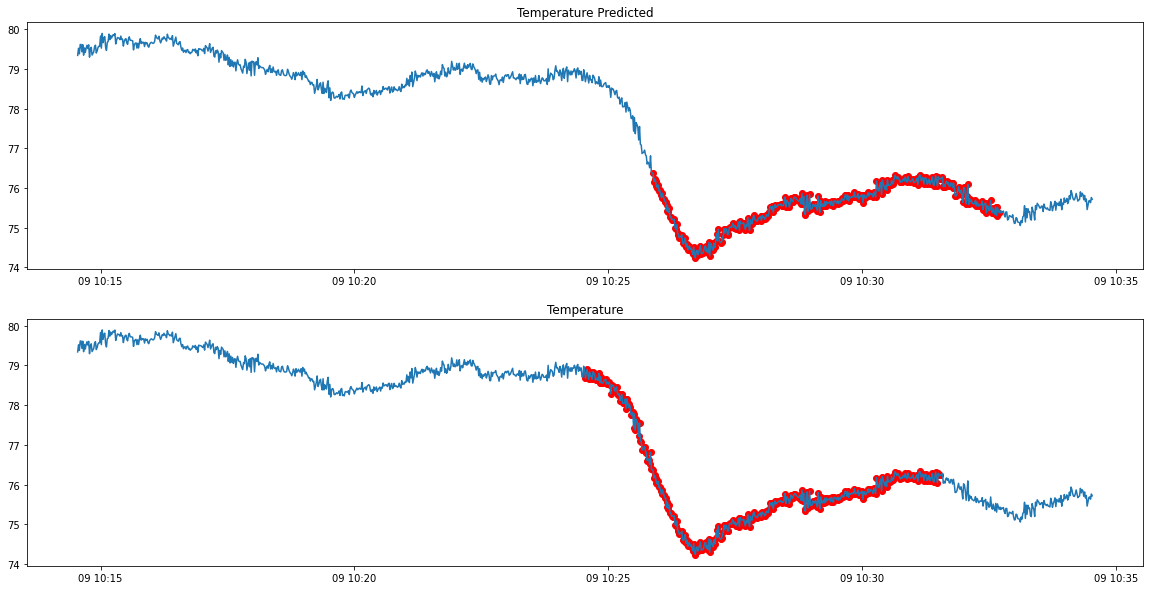

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(df.anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [69]:
print(f"""F1 = {f1_score(df.anomaly, prediction)}
FAR = {far(df.anomaly, prediction)}
MAR = {mar(df.anomaly, prediction)}""")

F1 = 0.819672131147541
FAR = 0.08981233243967829
MAR = 0.18952618453865336


### Применение метода ко всем датасетам

In [3]:
from utils.pipeline import Pipeline, Predictor

In [4]:
class LSTM_AD_Predictor(Predictor):
    def make_prediction(self, df):
        
        SS = StandardScaler()
        df = df.drop(['anomaly','changepoint'], axis=1)
             
        x_train = np.array(SS.fit_transform(df[:Config.train_size]))
        x_train = create_sequences(x_train, Config.TIME_STEPS)

        lstm_ad = LSTM_AD().fit(x_train)
        x_test = np.array(SS.transform(df))
        x_test = create_sequences(x_test, Config.TIME_STEPS)

        predictions = lstm_ad.predict(x_test)

        r = pd.Series(np.sum(np.mean(np.abs(np.array(predictions) - x_test), axis=1), axis=1))
        health_r = r[:Config.train_size]
        
        UCL = health_r.quantile(Config.Q)
        anomalous_data = r > (3/2 * UCL)

        anomalous_data_indices = [] 
        for data_idx in range(Config.TIME_STEPS - 1, len(x_test) - Config.TIME_STEPS + 1):
            if np.all(anomalous_data[data_idx - Config.TIME_STEPS + 1 : data_idx]):
                anomalous_data_indices.append(data_idx - int(Config.TIME_STEPS // 6))

        prediction = pd.Series(data=0, index=df.index)
        prediction.iloc[anomalous_data_indices] = 1
        return prediction

Anomaly: valve1


IntProgress(value=0, description='Computing', max=16, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 5s 132ms/step - loss: 0.8776
Epoch 2/2
11/11 [==============================] - 1s 129ms/step - loss: 0.7872
Epoch 1/2
11/11 [==============================] - 7s 142ms/step - loss: 0.9022
Epoch 2/2
11/11 [==============================] - 1s 127ms/step - loss: 0.8094
Epoch 1/2
11/11 [==============================] - 5s 134ms/step - loss: 0.9227
Epoch 2/2
11/11 [==============================] - 1s 130ms/step - loss: 0.8294
Epoch 1/2
11/11 [==============================] - 6s 160ms/step - loss: 0.8833
Epoch 2/2
11/11 [==============================] - 2s 134ms/step - loss: 0.7832
Epoch 1/2
11/11 [==============================] - 6s 132ms/step - loss: 0.9028
Epoch 2/2
11/11 [==============================] - 1s 131ms/step - loss: 0.8019
Epoch 1/2
11/11 [==============================] - 5s 131ms/step - loss: 0.8946
Epoch 2/2
11/11 [==============================] - 1s 130ms/step - loss: 0.7934
Epoch 1/2
11/11 [=======================

IntProgress(value=0, description='Computing', max=4, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 6s 138ms/step - loss: 0.8923
Epoch 2/2
11/11 [==============================] - 2s 149ms/step - loss: 0.8098
Epoch 1/2
11/11 [==============================] - 10s 198ms/step - loss: 0.8842
Epoch 2/2
11/11 [==============================] - 2s 151ms/step - loss: 0.7958
Epoch 1/2
11/11 [==============================] - 6s 118ms/step - loss: 0.8898
Epoch 2/2
11/11 [==============================] - 1s 118ms/step - loss: 0.8017
Epoch 1/2
11/11 [==============================] - 7s 172ms/step - loss: 0.8692
Epoch 2/2
11/11 [==============================] - 1s 129ms/step - loss: 0.7698
F1 = 0.5861297539149888

FAR = 0.02254025044722719

MAR = 0.5682267633487146

Anomaly: other0


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 6s 129ms/step - loss: 0.8919
Epoch 2/2
11/11 [==============================] - 2s 139ms/step - loss: 0.7953
F1 = 0.9063829787234042

FAR = 0.08525033829499323

MAR = 0.05543237250554324

Anomaly: other1


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 6s 129ms/step - loss: 0.9160
Epoch 2/2
11/11 [==============================] - 1s 129ms/step - loss: 0.7961
F1 = 0.9237875288683602

FAR = 0.08748317631224764

MAR = 0.0024937655860349127

Anomaly: other2


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 5s 131ms/step - loss: 0.9098
Epoch 2/2
11/11 [==============================] - 1s 129ms/step - loss: 0.8124
F1 = 0.9172259507829977

FAR = 0.09932885906040269

MAR = 0.0

Anomaly: other3


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 5s 131ms/step - loss: 0.9147
Epoch 2/2
11/11 [==============================] - 1s 129ms/step - loss: 0.7963
F1 = 0.7896440129449838

FAR = 0.08795669824086604

MAR = 0.21035598705501618

Anomaly: other4


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 9s 171ms/step - loss: 0.8521
Epoch 2/2
11/11 [==============================] - 3s 322ms/step - loss: 0.7545
F1 = 0.0

FAR = 0.0

MAR = 1.0

Anomaly: other5


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 7s 118ms/step - loss: 0.9082
Epoch 2/2
11/11 [==============================] - 1s 117ms/step - loss: 0.8041
F1 = 0.8012048192771084

FAR = 0.0

MAR = 0.3316582914572864

Anomaly: other6


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 9s 145ms/step - loss: 0.8524
Epoch 2/2
11/11 [==============================] - 1s 117ms/step - loss: 0.7855
F1 = 0.5757575757575758

FAR = 0.0

MAR = 0.5957446808510638

Anomaly: other7


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 6s 138ms/step - loss: 0.9013
Epoch 2/2
11/11 [==============================] - 1s 135ms/step - loss: 0.7995
F1 = 0.9766763848396501

FAR = 0.005383580080753701

MAR = 0.0345821325648415

Anomaly: other8


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 6s 119ms/step - loss: 0.8874
Epoch 2/2
11/11 [==============================] - 1s 118ms/step - loss: 0.7674
F1 = 0.8900255754475703

FAR = 0.08771929824561403

MAR = 0.10921501706484642

Anomaly: other9


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 6s 142ms/step - loss: 0.8878
Epoch 2/2
11/11 [==============================] - 1s 118ms/step - loss: 0.8034
F1 = 0.8317214700193424

FAR = 0.0

MAR = 0.28807947019867547

Anomaly: other10


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 5s 149ms/step - loss: 0.9085
Epoch 2/2
11/11 [==============================] - 1s 119ms/step - loss: 0.8067
F1 = 0.729903536977492

FAR = 0.0

MAR = 0.4253164556962025

Anomaly: other11


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 5s 132ms/step - loss: 0.9158
Epoch 2/2
11/11 [==============================] - 2s 172ms/step - loss: 0.8279
F1 = 0.9792935444579781

FAR = 0.022818791946308724

MAR = 0.0

Anomaly: other12


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 6s 133ms/step - loss: 0.8768
Epoch 2/2
11/11 [==============================] - 1s 125ms/step - loss: 0.7870
F1 = 0.2560296846011132

FAR = 0.09005376344086022

MAR = 0.8287841191066998

Anomaly: other13


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 6s 121ms/step - loss: 0.8767
Epoch 2/2
11/11 [==============================] - 1s 118ms/step - loss: 0.7640
F1 = 0.0

FAR = 0.0

MAR = 1.0

Anomaly: all


IntProgress(value=0, description='Computing', max=34, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 6s 165ms/step - loss: 0.8942
Epoch 2/2
11/11 [==============================] - 2s 163ms/step - loss: 0.8001
Epoch 1/2
11/11 [==============================] - 10s 227ms/step - loss: 0.9012
Epoch 2/2
11/11 [==============================] - 1s 128ms/step - loss: 0.7869
Epoch 1/2
11/11 [==============================] - 9s 165ms/step - loss: 0.9077
Epoch 2/2
11/11 [==============================] - 2s 214ms/step - loss: 0.8079
Epoch 1/2
11/11 [==============================] - 9s 257ms/step - loss: 0.9226
Epoch 2/2
11/11 [==============================] - 5s 464ms/step - loss: 0.8001
Epoch 1/2
11/11 [==============================] - 11s 267ms/step - loss: 0.8974
Epoch 2/2
11/11 [==============================] - 6s 516ms/step - loss: 0.8020
Epoch 1/2
11/11 [==============================] - 8s 241ms/step - loss: 0.8940
Epoch 2/2
11/11 [==============================] - 2s 175ms/step - loss: 0.7812
Epoch 1/2
11/11 [=====================

2022-04-20 23:52:28.457079: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch 1/2
11/11 [==============================] - 5s 120ms/step - loss: 0.9099
Epoch 2/2
11/11 [==============================] - 1s 119ms/step - loss: 0.8023
Epoch 1/2
11/11 [==============================] - 12s 184ms/step - loss: 0.8811
Epoch 2/2
11/11 [==============================] - 2s 191ms/step - loss: 0.7637
Epoch 1/2
11/11 [==============================] - 5s 121ms/step - loss: 0.8874
Epoch 2/2
11/11 [==============================] - 1s 120ms/step - loss: 0.8123
Epoch 1/2
11/11 [==============================] - 13s 367ms/step - loss: 0.9019
Epoch 2/2
11/11 [==============================] - 4s 331ms/step - loss: 0.8026
Epoch 1/2
11/11 [==============================] - 7s 172ms/step - loss: 0.9336
Epoch 2/2
11/11 [==============================] - 4s 398ms/step - loss: 0.8352
Epoch 1/2
11/11 [==============================] - 11s 303ms/step - loss: 0.8587
Epoch 2/2
11/11 [==============================] - 3s 291ms/step - loss: 0.7781
Epoch 1/2
11/11 [====================

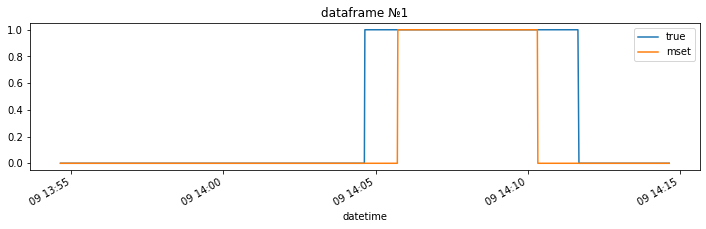

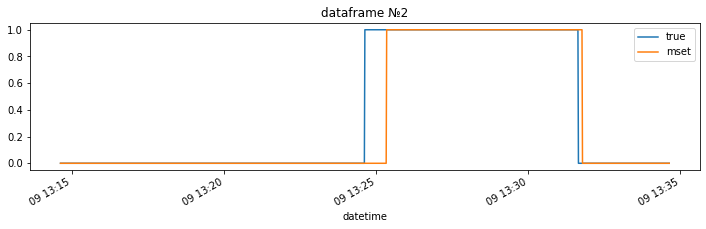

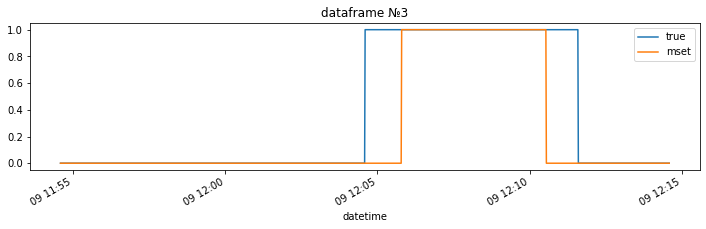

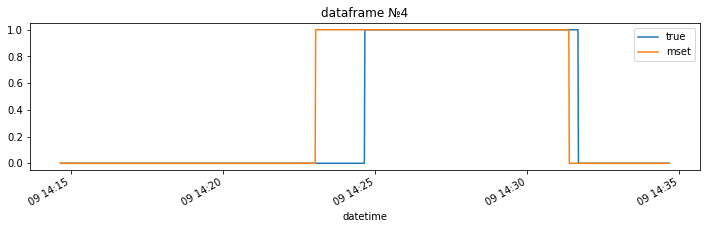

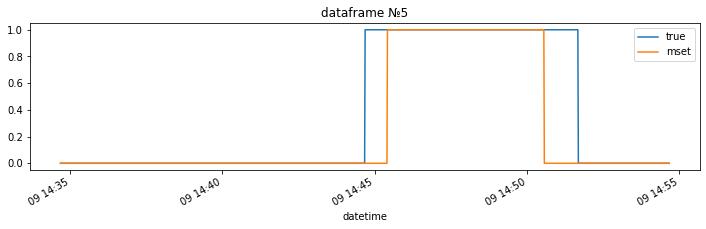

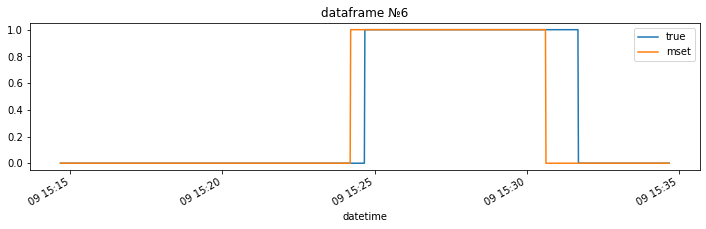

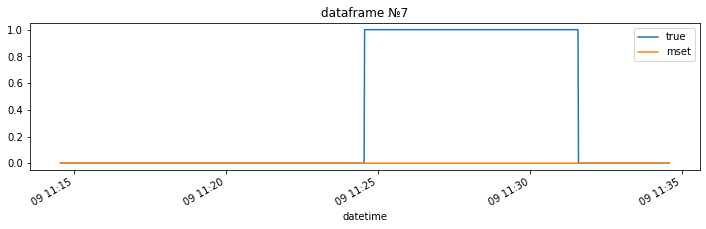

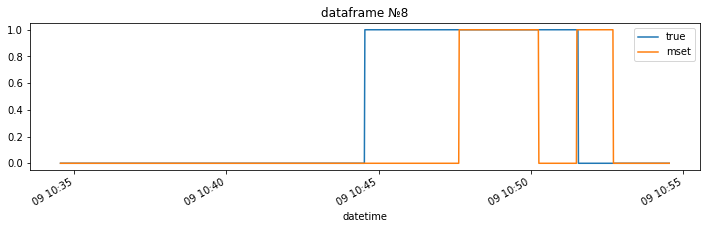

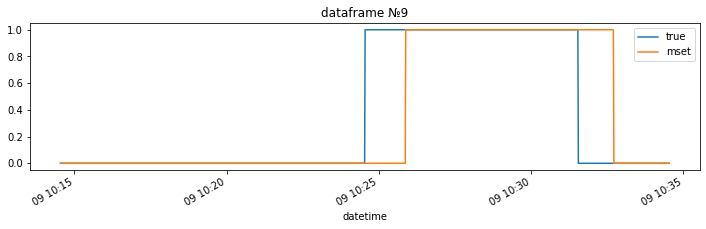

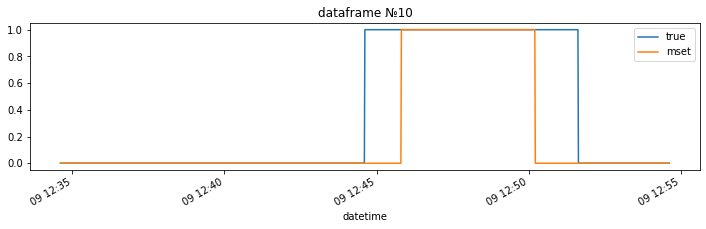

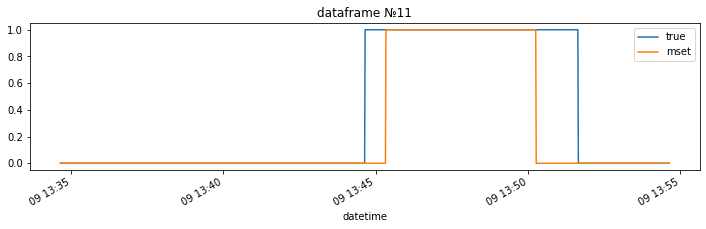

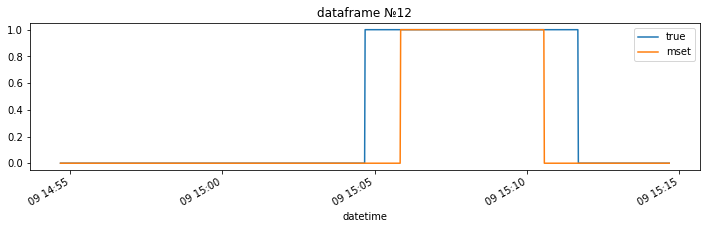

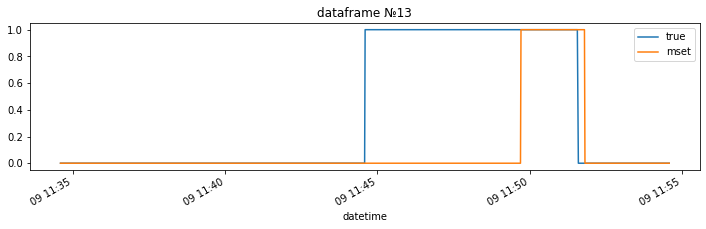

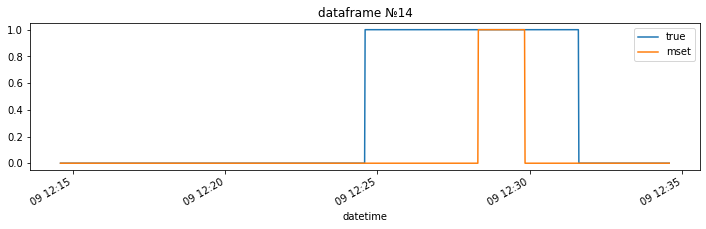

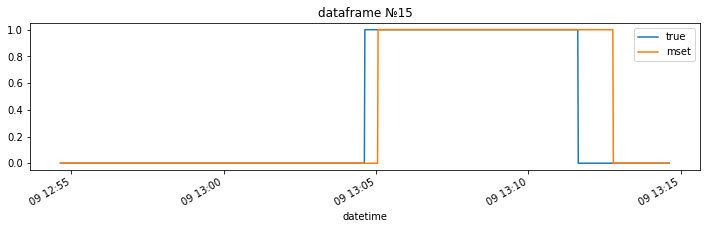

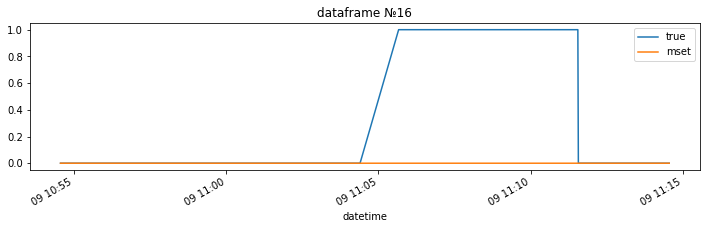

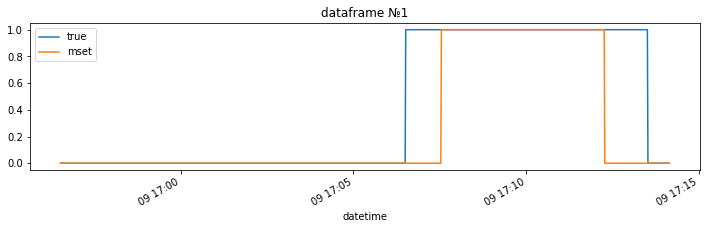

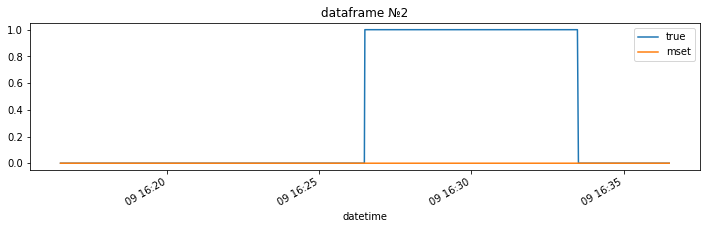

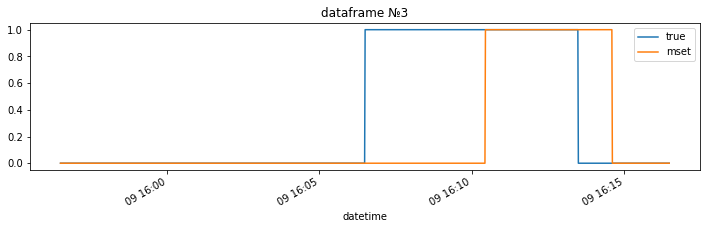

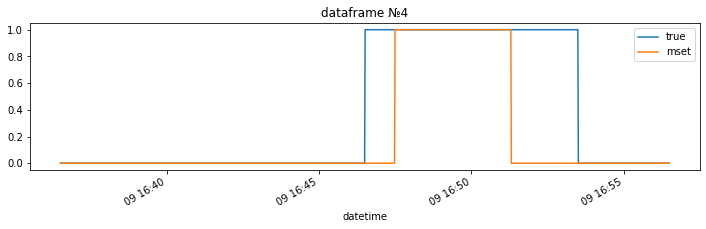

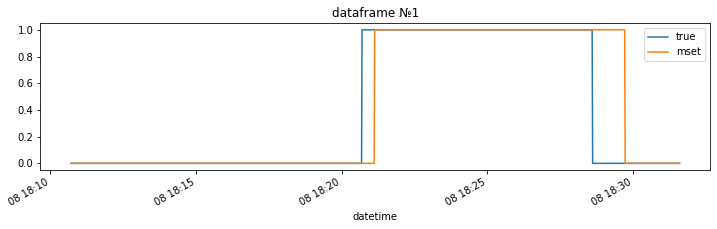

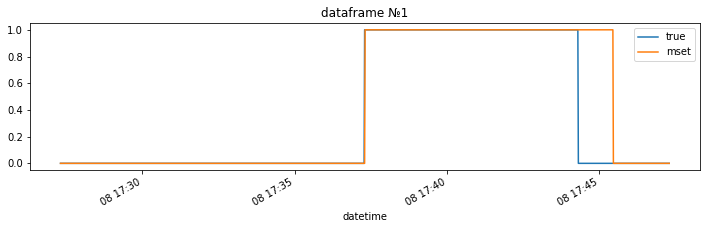

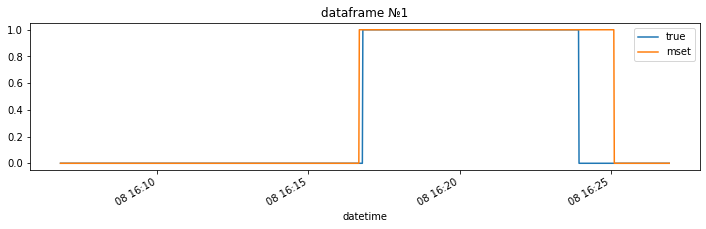

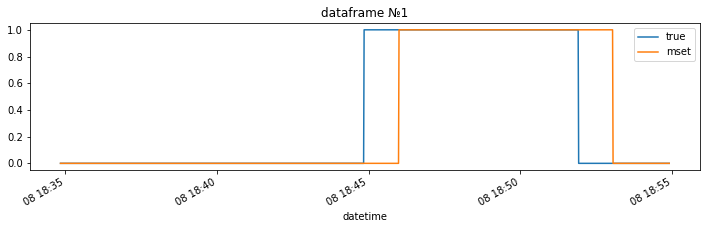

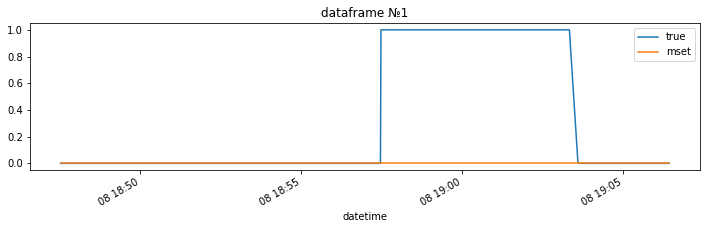

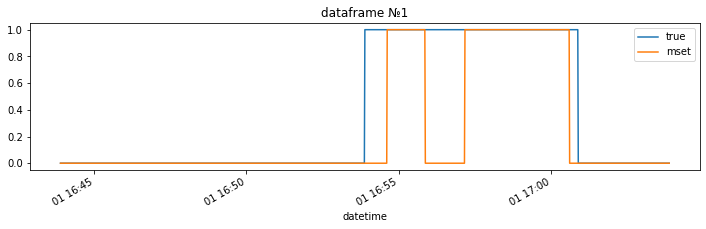

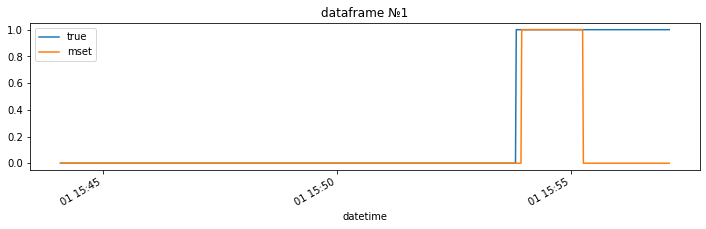

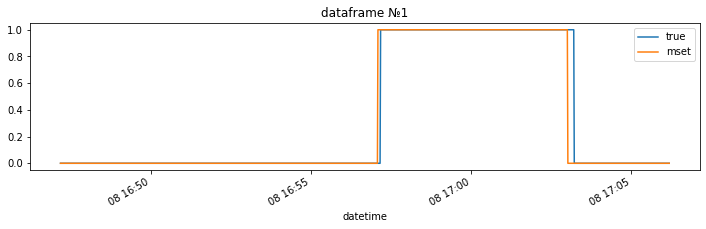

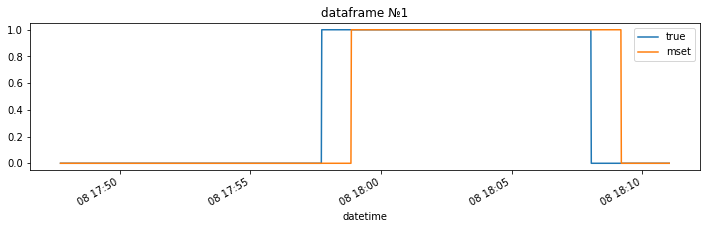

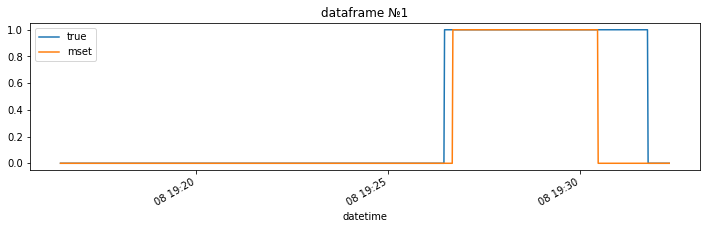

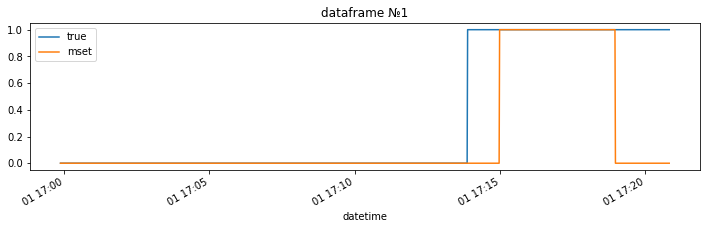

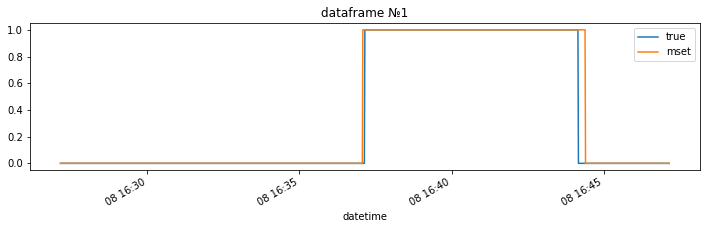

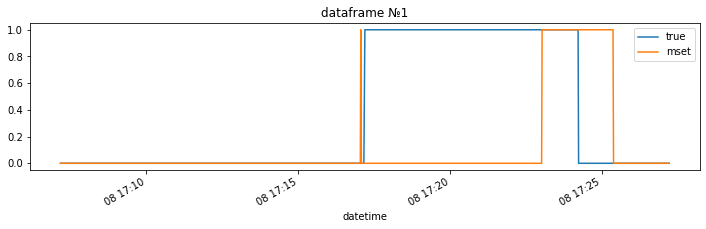

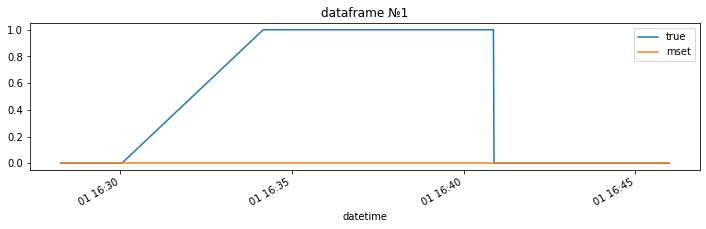

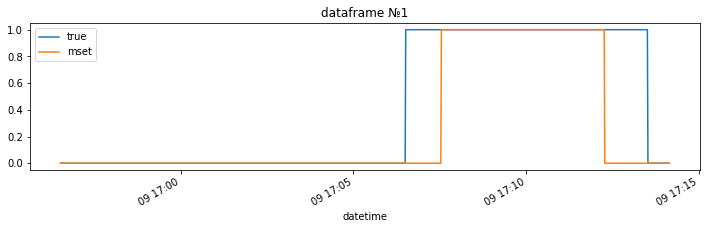

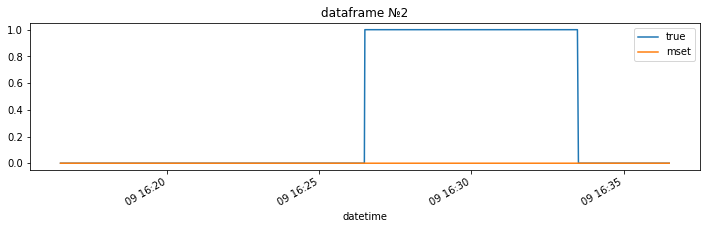

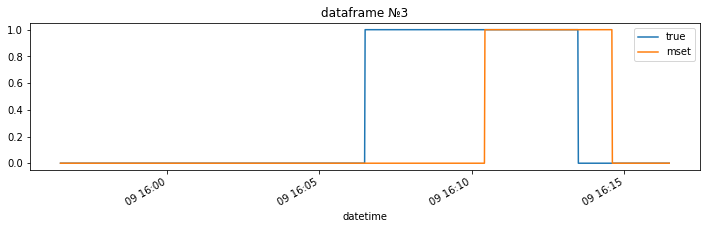

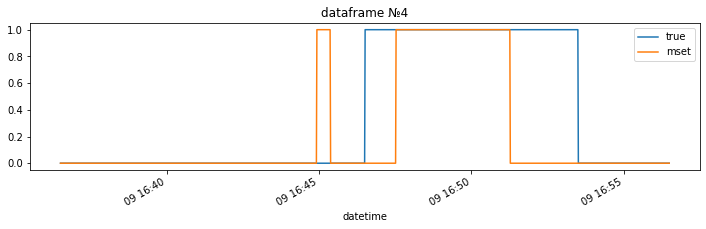

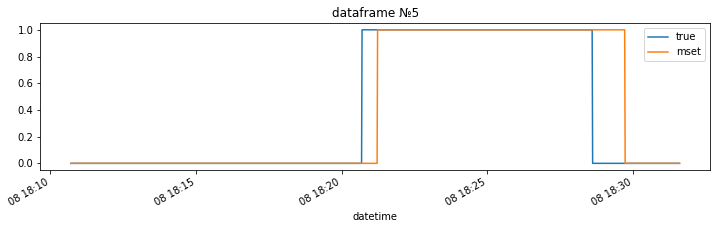

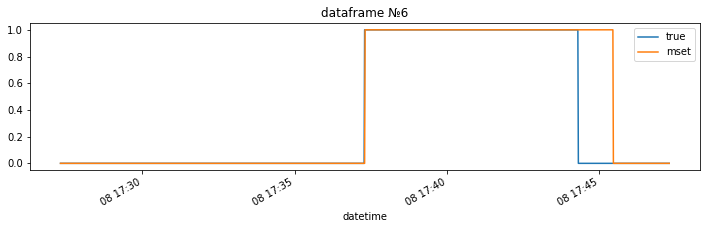

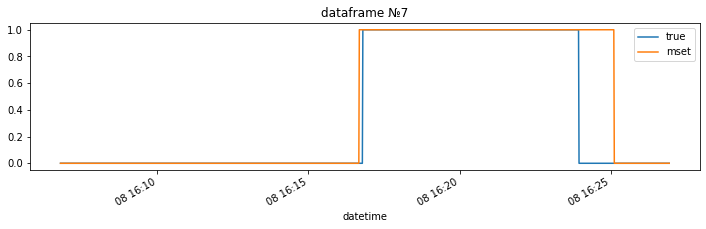

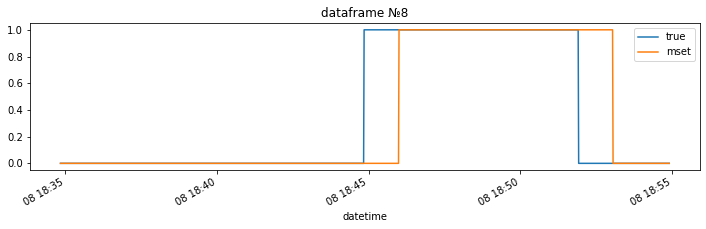

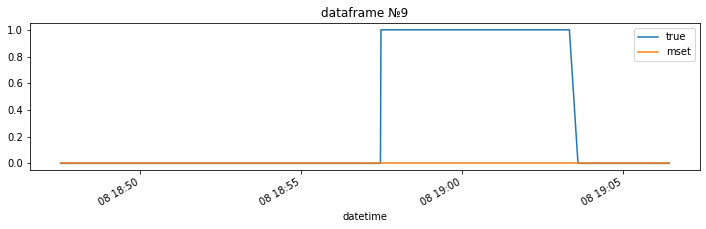

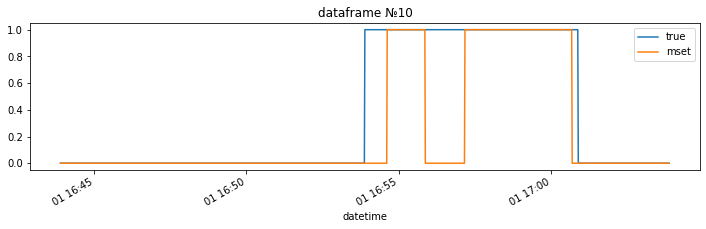

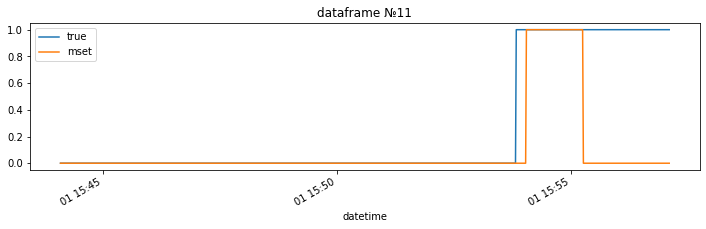

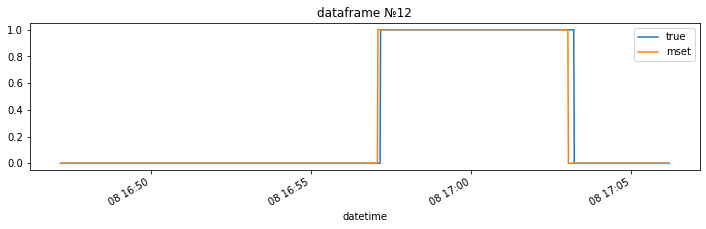

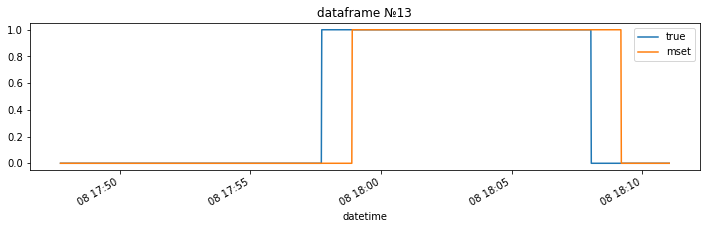

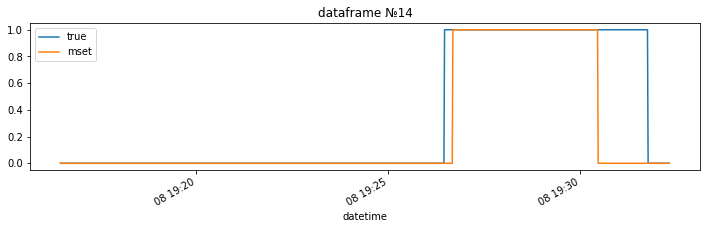

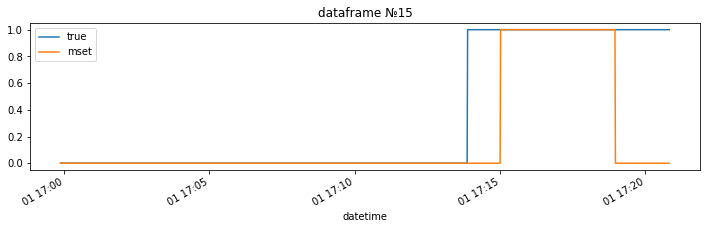

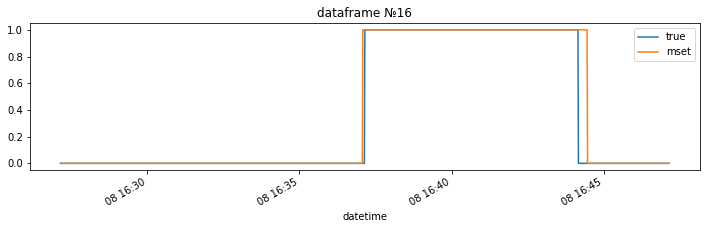

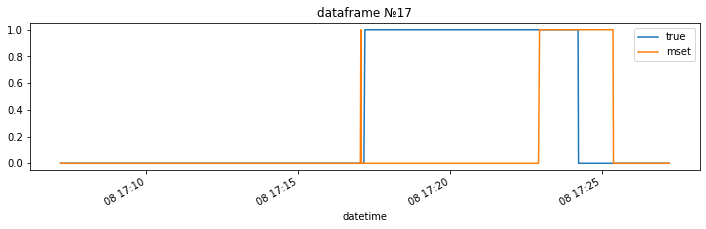

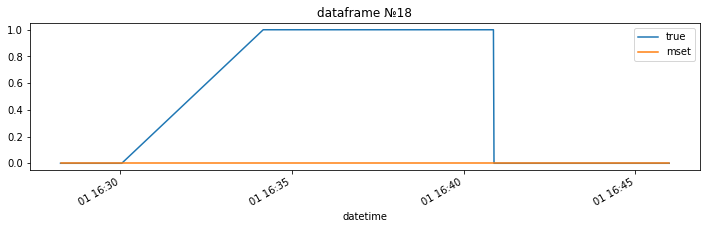

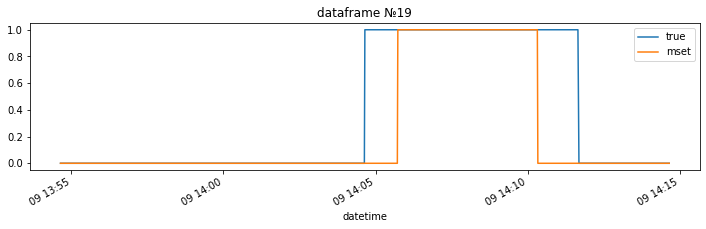

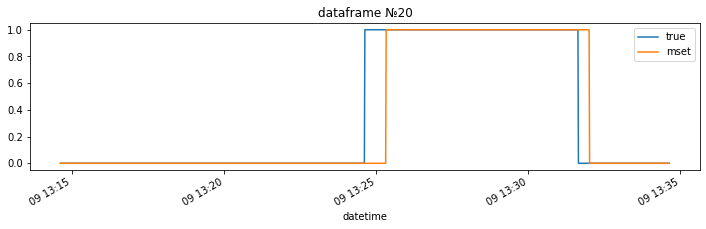

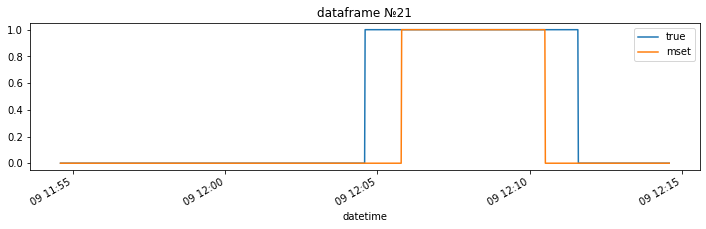

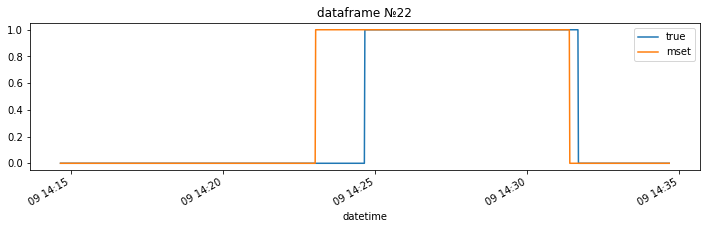

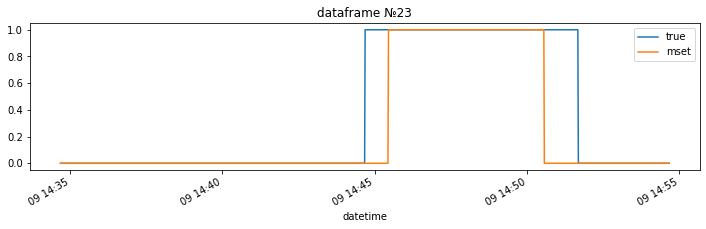

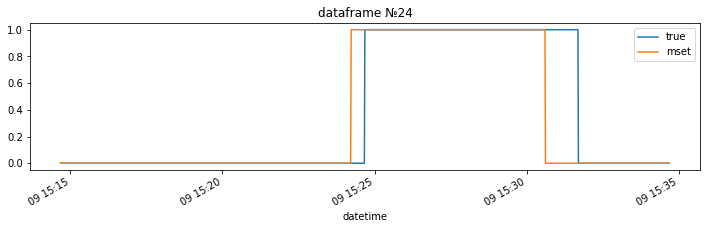

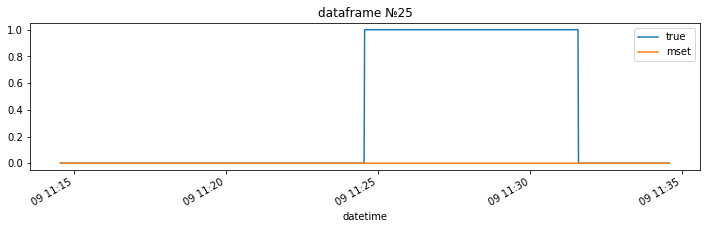

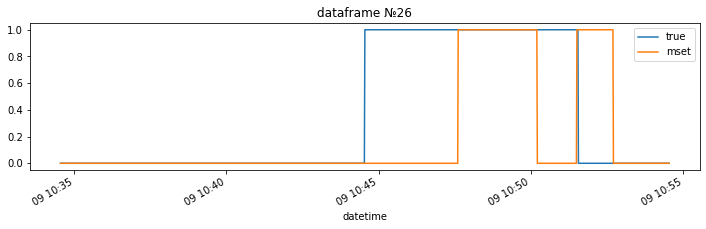

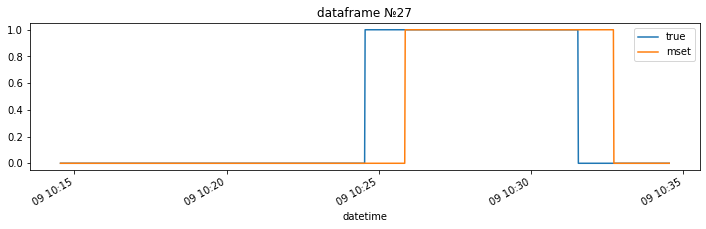

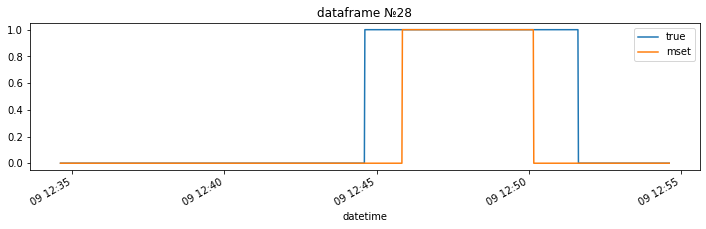

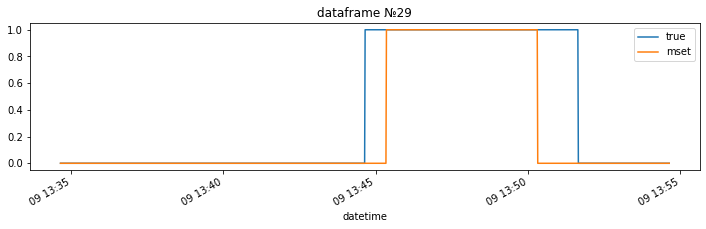

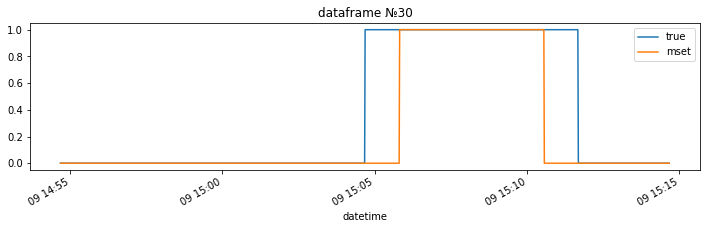

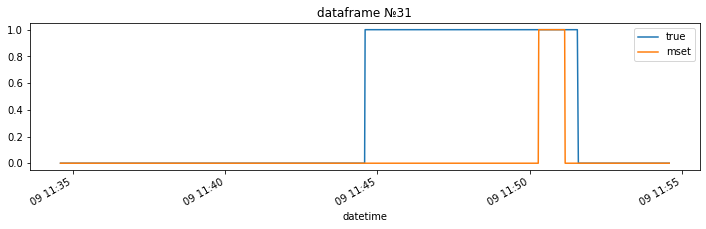

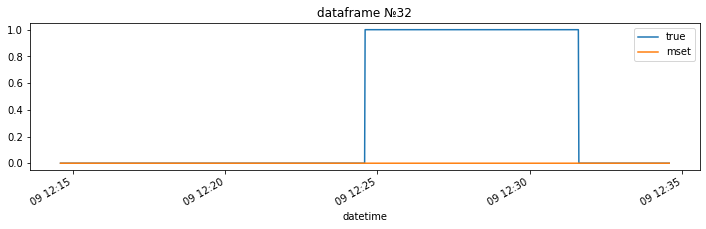

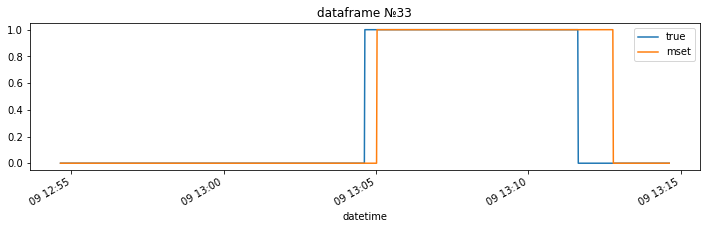

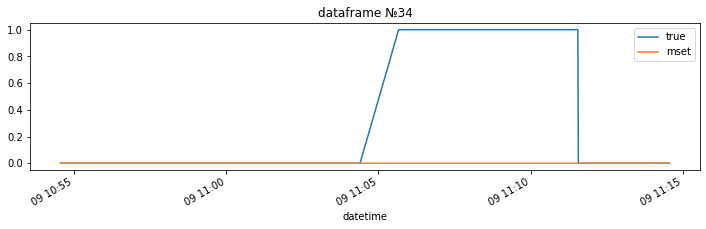

In [6]:
from utils.data import load_df

anomaly_types = ("valve1", "valve2", "other", "all")
anomaly_groups = dict()

for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            anomaly_groups[f"{anomaly_type}{i}"] = [df, ]
    else:
        anomaly_groups[f"{anomaly_type}"] = list_of_df

lstm_ad_predictor = LSTM_AD_Predictor()
p = Pipeline()

metrics = dict()

for anomaly_type, list_of_df in anomaly_groups.items():
    metric = p.run(list_of_df, lstm_ad_predictor, anomaly_description=anomaly_type)
    metrics[anomaly_type] = metric

In [7]:
from utils.data import show_score_table

In [8]:
show_score_table(metrics)

metric | valve1 | valve2 | other0 | other1 | other2 | other3 | other4 | other5 | other6 | other7 | other8 | other9 | other10 | other11 | other12 | other13 | all
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.72 | 0.59 | 0.91 | 0.92 | 0.92 | 0.79 | 0.0 | 0.8 | 0.58 | 0.98 | 0.89 | 0.83 | 0.73 | 0.98 | 0.26 | 0.0 | 0.72
FAR |0.03 | 0.02 | 0.09 | 0.09 | 0.1 | 0.09 | 0.0 | 0.0 | 0.0 | 0.01 | 0.09 | 0.0 | 0.0 | 0.02 | 0.09 | 0.0 | 0.03
MAR |0.4 | 0.57 | 0.06 | 0.0 | 0.0 | 0.21 | 1.0 | 0.33 | 0.6 | 0.03 | 0.11 | 0.29 | 0.43 | 0.0 | 0.83 | 1.0 | 0.4